In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from create_dataset import get_multi_faults

projects = ['Lang', 'Chart', 'Time', 'Closure', 'Math']
SEARCH_RESULTS_DIR = './fault_data/multi'
DATE_DIR = "./resources/metadata"
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [2]:
def to_date(s):
    return date.fromisoformat(s.split()[0])
    
date_df = pd.DataFrame(columns=['project', 'fault', 'buggy_date', 'fixed_date'])
for project in projects:
    with open(os.path.join(DATE_DIR, project), 'r') as f:
        for l in f:
            fault, buggy_date, fixed_date = l.strip().split(',')
            date_df = date_df.append(
                pd.Series(
                    [project, int(fault), to_date(buggy_date), to_date(fixed_date)],
                    index=date_df.columns
                ), ignore_index=True
            )

date_df

,project,fault,buggy_date,fixed_date
0,Lang,1,2013-07-07,2013-07-26
1,Lang,3,2013-05-16,2013-05-19
2,Lang,4,2013-04-22,2013-04-23
3,Lang,5,2012-12-17,2013-01-03
4,Lang,6,2012-11-13,2012-11-20
...,...,...,...,...
391,Math,102,2008-01-07,2008-01-09
392,Math,103,2007-07-16,2007-07-22
393,Math,104,2007-06-14,2007-06-20
394,Math,105,2006-07-06,2006-07-06


In [3]:
def get_exist_df(fault_dir):
    exist_df = pd.DataFrame(columns=['project', 'version', 'fault'])
    multi_faults = {
        project: get_multi_faults(fault_dir, project) for project in projects
    }
    fault_ids = {project: set() for project in projects}

    # multi-fault-check
    for dirname in os.listdir(fault_dir):
        project, fault, base = tuple(dirname.split('-'))
        exists = fault in multi_faults[project][base] if base in multi_faults[project] else False
        exist_df = exist_df.append({
            'project': project, 
            'version': int(base),
            'fault': int(fault),
            'exists': exists
        }, ignore_index=True)
        fault_ids[project].add(int(base))
        fault_ids[project].add(int(fault))
        
    for project in fault_ids:
        for fault in fault_ids[project]:
            exist_df = exist_df.append({
                'project': project, 
                'version': fault,
                'fault': fault,
                'exists': True
            }, ignore_index=True)

    exist_df.exists = exist_df.exists.astype(bool)
    return exist_df

def get_containing_faults(exist_df, project, version):
    return exist_df[
        exist_df.exists
        & (exist_df.project == project)
        & (exist_df.version == version)
    ].sort_values(by='fault').fault.values

def get_num_containing_faults(exist_df):
    return exist_df[exist_df.exists].groupby(['project', 'version']).fault.count().sort_values()

def plot_hist(exist_df, figsize=None, savepath=None, color_palette='Set2'):
    num_faults = get_num_containing_faults(exist_df)

    all_versions = exist_df[['project', 'version']].drop_duplicates().shape[0]
    multiple_fault_versions = (num_faults > 1).sum()
    print("**** # version with multiple bugs:", multiple_fault_versions, all_versions, f"{round(multiple_fault_versions/all_versions * 100, 2)}%")
    print("**** # version with >= 10 bugs:", (num_faults >= 10).sum())
    print("**** # version with >= 20 bugs:", (num_faults >= 20).sum())

    num_faults.name = 'exists'
    num_faults = num_faults.to_frame().sort_values(by='project')
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    sns.histplot(data=num_faults, x='exists',
        hue='project', multiple='stack',
        discrete=True, zorder=10,
        palette=sns.color_palette(color_palette)[:len(projects)])
    plt.xlabel('# found bugs in each buggy version')
    plt.ylabel('# buggy versions')
    plt.xticks(range(1, num_faults['exists'].max()+1))
    plt.grid(axis='y')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    if savepath:
        plt.savefig(savepath)
    plt.show()
    
def get_lifespan_df(exist_df):
    df = exist_df[exist_df.exists].copy()
    df = df.groupby(['project', 'fault']).version.max()
    df.name = 'first_available_version'
    df = df.to_frame().reset_index()
    df = df.merge(date_df[['project', 'fault', 'fixed_date']], left_on=['project', 'fault'], right_on=['project', 'fault'])
    df = df.merge(date_df[['project', 'fault', 'buggy_date']], left_on=['project', 'first_available_version'], right_on=['project', 'fault'], suffixes=('', '_f'))
    df['lifespan_in_versions'] = df.first_available_version - df.fault
    df['lifespan_in_days'] = (df.fixed_date - df.buggy_date).apply(lambda d: d.days)
    return df[['project', 'fault', 'lifespan_in_versions', 'lifespan_in_days']]

def plot_sorted_lifespan(lifespan_df, lifespan_colname='lifespan_in_days', savepath=None):
    lifespan_df['ID'] = lifespan_df['project'] + '-' + lifespan_df['fault'].astype(str) + 'b'
    lifespan_df = lifespan_df.sort_values(by=lifespan_colname)

    print('sorted liftspan')
    version_has_longest_lifespan = lifespan_df.sort_values(by=lifespan_colname, ascending=False).iloc[0]
    print("****")
    print(version_has_longest_lifespan)
    print("*****Average lifespan (std)", lifespan_df[lifespan_colname].mean().round(0), lifespan_df[lifespan_colname].std().round(0))

    plt.figure(figsize=(6, 4))
    sns.barplot(data=lifespan_df, x='ID', y=lifespan_colname, zorder=10)
    plt.grid(axis='y')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.xlabel(f'{len(lifespan_df.ID.unique())} bugs in Defects4J')
    plt.ylabel(lifespan_colname.replace('_', ' '))
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()


In [4]:
# our search
exist_df = get_exist_df(SEARCH_RESULTS_DIR)
print(exist_df[exist_df.version != exist_df.fault].shape[0])
print(exist_df[exist_df.version != exist_df.fault].exists.sum())

2907
2620


In [5]:
# the number of bugs in each buggy version
get_num_containing_faults(exist_df)

project  version
Chart    1           1
Math     36          1
Lang     1           1
Closure  1           1
Lang     40          1
                    ..
Closure  94         23
         95         23
         91         23
         89         23
         90         24
Name: fault, Length: 326, dtype: int64

**** # version with multiple bugs: 311 326 95.4%
**** # version with >= 10 bugs: 126
**** # version with >= 20 bugs: 22


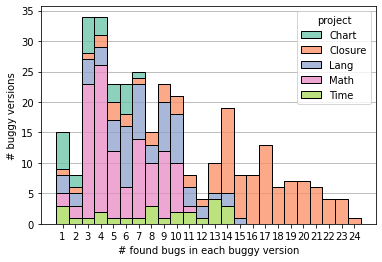

In [6]:
plot_hist(exist_df, figsize=(6, 4), savepath='./figures/hist.pdf')

In [7]:
get_containing_faults(exist_df, 'Closure', 90)

array([11, 24, 25, 42, 43, 44, 48, 51, 58, 62, 69, 71, 72, 73, 77, 78, 81,
       82, 84, 85, 87, 88, 89, 90], dtype=object)

In [8]:
lifespan_df = get_lifespan_df(exist_df)
lifespan_df.sort_values(by='lifespan_in_days')

,project,fault,lifespan_in_versions,lifespan_in_days
162,Lang,28,0,0
161,Lang,25,0,0
163,Lang,29,0,0
166,Lang,33,0,0
167,Lang,34,0,0
...,...,...,...,...
285,Math,91,15,1028
284,Math,90,16,1047
304,Time,5,22,1101
303,Time,4,23,1127


sorted liftspan
****
project                     Lang
fault                         41
lifespan_in_versions          24
lifespan_in_days            1187
ID                      Lang-41b
Name: 169, dtype: object
*****Average lifespan (std) 155.0 246.0


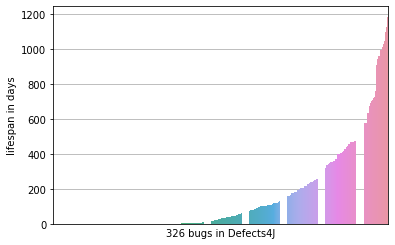

In [9]:
plot_sorted_lifespan(lifespan_df, savepath='figures/lifespan.pdf')